Example of plotting spatial gene expression patterns

data files needed to run are available at SCP: https://singlecell.broadinstitute.org/single_cell/study/SCP979/<br>
please download:<br>
lambdas_pmeans_output_mob.tsv<br>
coordinate_registration_mob.p<br>
information_mob.p<br>

In [1]:
import os
import re
import glob
import numpy
import matplotlib
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from matplotlib.transforms import Affine2D
from matplotlib.collections import PathCollection
%matplotlib inline
matplotlib.rcParams.update({'axes.linewidth': 0.25,
                            'xtick.major.size': 2,
                            'xtick.major.width': 0.25,
                            'ytick.major.size': 2,
                            'ytick.major.width': 0.25,
                            'pdf.fonttype': 42,
                            'pdf.fonttype':42,
                            'font.sans-serif': 'Arial'})

In [9]:
def read_array_metadata(metadata,filename,n_levels, extraplot=None):
    array_metadata = metadata[metadata['Count file'] == filename]
    array_levels = [array_metadata['Level %d'%(idx+1)].values[0] for idx in range(0,n_levels)]
    
    if extraplot != None:
        array_levels = array_metadata['Extra_plot_level'].tolist()
    return array_levels

In [3]:
# Load Lambda pmean df
path = '../../smomics_data'
filename = os.path.join(path, 'lambdas_pmeans_output_mob.tsv')   
lambda_posterior_means = pd.read_csv(filename, index_col=0, sep='\t', header=[0,1])


In [4]:
# Load registration file
reg_file = os.path.join(path, 'coordinate_registration_mob.p')
registered_coordinates_dict = pickle.load(open(reg_file,'rb'), encoding='bytes') 

In [5]:
# Load sample_information file
info_file = os.path.join(path, 'information_mob.p')
info = pickle.load(open(info_file,'rb')) 
metadata = info['metadata']
n_levels = info['n_levels']

In [6]:
# Take exp()
lambda_posterior_means = numpy.exp(lambda_posterior_means-1)

In [7]:
# Pick genes in regions:
regions = ['GL', 'GR', 'MI', 'OPL']
genes = ['Nrsn1','Nos1ap','Cdh23','Prss12']

# Pick variables to compare
variables_of_interest = ['MOB,8w']

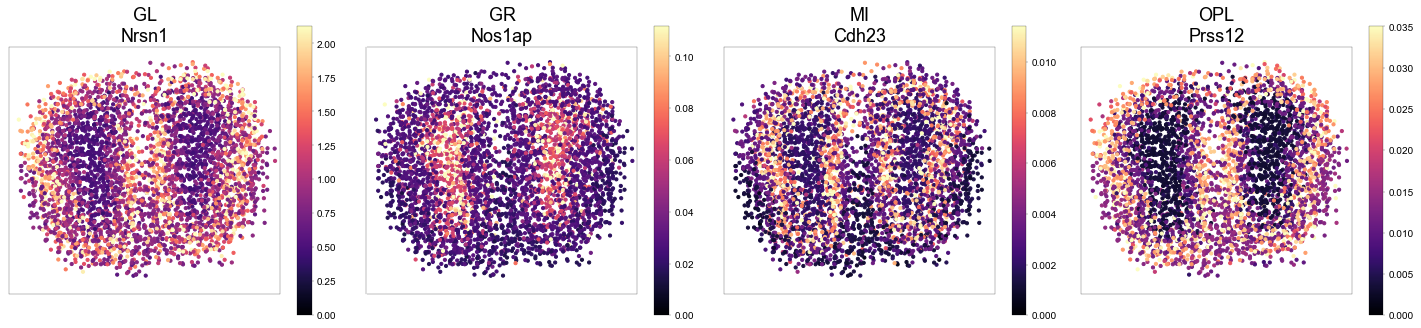

In [10]:
## Same, but one gene in each figure, ie. no subplots

# initialize a figure
fig = matplotlib.pyplot.figure(figsize=(20, 7))

rotation = [-60, -60, -60, -60, -60]

axes = []
for ax_idx in range(0,1):
    for i in range(len(genes)):
        ax = plt.subplot2grid((1, len(genes)), (ax_idx, i))
        axes.append(ax)                    


############# SPLOTCH ############# 
for gidx, gene in enumerate(genes):
    
    # get the names of the count files
    count_files = numpy.array(list(lambda_posterior_means.columns.levels[0]))

    # use the same color scale across the arrays
    vmin,vmax = 0,numpy.percentile(lambda_posterior_means.loc[gene].values,95)
           
    axes[gidx].set_aspect('equal')
    
    axes[gidx].set_xticks([])
    axes[gidx].set_yticks([])
    
    axes[gidx].set_xlim([-11,11])
    axes[gidx].set_ylim([-10,10])

    cbmap = [None for _ in range(0,len(genes))]
    
    # loop over the count files
    for n,count_file in enumerate(count_files):
    
        # see if the current array has the level variable of interest
        try:
            ax_idx = variables_of_interest.index(read_array_metadata(metadata,count_file,n_levels)[0])
        except ValueError:
            continue
        
        # move to the next array if the current array has not been registered 
        if count_file not in registered_coordinates_dict:
            continue
    
        # for each ST spot on the array, let us get its registered coordinate if available
        coordinates_found = numpy.zeros(len(list(lambda_posterior_means[count_file].columns))) # indicator of being registered
        coordinates = []  
        for coord_idx,coordinate in enumerate(list(lambda_posterior_means[count_file].columns)):
            if coordinate in registered_coordinates_dict[count_file]:
                coordinates_found[coord_idx] = 1
                coordinates.append(list(map(float,registered_coordinates_dict[count_file][coordinate].split('_'))))
        coordinates = numpy.array(coordinates)
        x_coordinates = coordinates[:,0]
        y_coordinates = coordinates[:,1]

        # visualize the registered ST spots
        cbmap[gidx] = axes[gidx].scatter(x_coordinates,y_coordinates,
                               s=10, c=lambda_posterior_means[count_file].loc[gene][coordinates_found > 0],
                               cmap='magma',vmin=vmin,vmax=vmax,marker='o')

    # Rotation
    r = Affine2D().rotate_deg(rotation[gidx])

    for x in axes[gidx].collections:
        trans = x.get_transform()
        x.set_transform(r+trans)
        if isinstance(x, PathCollection):
            transoff = x.get_offset_transform()
            x._transOffset = r+transoff
            
    # add colorbars
    for ax_idx in range(0, len(genes)):
        if cbmap[ax_idx] is not None:
            cbar = matplotlib.pyplot.colorbar(cbmap[ax_idx],ax=axes[gidx],shrink=0.6)    
  
    # Set gene name
    uu =0
    axes[gidx].set_title(regions[gidx] + '\n' + gene, fontsize=18)
    
plt.tight_layout()
